In [1]:
%pwd 
%cd ..

d:\MASTERING_LLMs\FineTuning


d:\MASTERING_LLMs\llmEnv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from items import Item

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor


In [3]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [4]:
load_dotenv()
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")
hf_token = os.environ["HUGGINGFACE_API_KEY"]

In [5]:
login(hf_token)

In [6]:
%matplotlib inline

In [7]:
with open("train.pkl", 'rb') as file:
    train = pickle.load(file)
with open("test.pkl", 'rb') as file:
    test = pickle.load(file)


In [62]:
# print(train[0].prompt)

In [9]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

In [10]:
for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [11]:
train[0].features

{'Product Dimensions': '1.46 x 1.6 x 1.25 inches',
 'Item Weight': '1.01 pounds',
 'Manufacturer': 'ARM Enterprises, Inc.',
 'Item model number': 'K85753-10',
 'Best Sellers Rank': {'Home & Kitchen': 818817,
  'Disposable Coffee Filters': 860},
 'Is Discontinued By Manufacturer': 'No',
 'Date First Available': 'July 6, 2012',
 'Material': 'Paper',
 'Compatible Devices': 'Breville, Keurig, Cuisinart, Mr. Coffee',
 'Brand': 'PERFECT POD',
 'Shape': 'Basket',
 'Number of Pieces': '500'}

In [12]:
feature_count = Counter()

for item in train:
    for f in item.features.keys():
        feature_count[f] += 1
feature_count.most_common(40)

[('Date First Available', 360086),
 ('Item Weight', 350562),
 ('Manufacturer', 349411),
 ('Brand', 340264),
 ('Best Sellers Rank', 330498),
 ('Item model number', 277584),
 ('Product Dimensions', 262484),
 ('Color', 183687),
 ('Is Discontinued By Manufacturer', 169839),
 ('Manufacturer Part Number', 145061),
 ('Material', 137429),
 ('Country of Origin', 121351),
 ('Style', 77676),
 ('Special Feature', 74703),
 ('Part Number', 74652),
 ('Batteries Required?', 73729),
 ('Package Dimensions', 72874),
 ('Item Dimensions LxWxH', 71352),
 ('Included Components', 67538),
 ('Model', 65088),
 ('Item Package Quantity', 58268),
 ('Size', 58242),
 ('Batteries Included?', 56894),
 ('OEM Part Number', 56105),
 ('Special Features', 53732),
 ('Exterior', 50616),
 ('Power Source', 50329),
 ('Vehicle Service Type', 49408),
 ('Finish Type', 46238),
 ('Voltage', 46078),
 ('Mounting Type', 38054),
 ('Model Name', 37561),
 ('Shape', 34832),
 ('Finish', 31981),
 ('Number of Items', 31890),
 ('Connectivity Te

In [13]:
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [14]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [15]:
average_weight = sum(weights)/len(weights)
average_weight

13.574213937985688

In [16]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [17]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [18]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380645.97950111434

In [19]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [20]:
def get_text_length(item):
    return len(item.test_prompt())

In [21]:
brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand] += 1
brands.most_common(40)

[('HP', 5513),
 ('Power Stop', 3596),
 ('Dell', 3276),
 ('Detroit Axle', 2720),
 ('Lenovo', 2446),
 ('Dorman', 2121),
 ('SAMSUNG', 1775),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1597),
 ('Evan Fischer', 1411),
 ('ASUS', 1392),
 ('Sony', 1277),
 ('Canon', 1214),
 ('Callahan BRAKE PARTS', 1148),
 ('Kohler', 1139),
 ('CURT', 1117),
 ('R1 Concepts', 1045),
 ('Rareelectrical', 964),
 ('Coverking', 935),
 ('Garage-Pro', 883),
 ('Kingston Brass', 852),
 ('Spectra Premium', 829),
 ('Moen', 827),
 ('WeatherTech', 826),
 ('Auto Dynasty', 822),
 ('DELTA FAUCET', 814),
 ('Apple', 795),
 ('Generic', 783),
 ('Cardone', 770),
 ('APS', 763),
 ('K&N', 754),
 ('GM', 748),
 ('EBC Brakes', 734),
 ('Walker', 725),
 ('AKKON', 652),
 ('TYC', 631),
 ('SPEC-D TUNING', 622),
 ('Covercraft', 615),
 ('A-Premium', 614),
 ('Intel', 612)]

In [22]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [23]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [24]:
get_features(train[0])

{'weight': 1.01,
 'rank': 409838.5,
 'text_length': 701,
 'is_top_electronics_brand': 0}

In [25]:
train[0]

<Perfect Pod EZ-Cup Paper Coffee Filters with Patented Lid for Single-Serve Coffee Brewers and Coffee Pods, Compatible with Keurig, 10-Pack (500 Filters) = $46.99>

In [26]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df
train_df =  list_to_dataframe(train)
test_df  = list_to_dataframe(test[:250])

In [27]:
train_df.head()

,weight,rank,text_length,is_top_electronics_brand,price
0,1.010000,409838.500000,701,0,46.99
1,13.574214,324173.000000,678,0,68.34
2,32.300000,285075.000000,817,0,177.99
3,0.100000,380645.979501,963,0,1.99
4,0.787500,380645.979501,711,0,217.31


In [28]:
np.random.seed(42)

feature_columns = [col for col in train_df.columns if col != 'price']
X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

model = LinearRegression()
model.fit(X_train,y_train)

for feature,coef in zip(feature_columns,model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")
print(f"R2 {r2}")

weight: 0.2640589113061323
rank: 5.170742699169696e-05
text_length: 0.0065764549465687746
is_top_electronics_brand: 197.78725295268103
Intercept: 183.1250878661437
MSE: 29252.872293005796
RMSE: 171.0347107841148
R2 0.1103732236030116


In [29]:
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $205.81 Truth: $244.99 Error: $39.18 SLE: 0.03 Item: ECR4Kids Double-Sided Mobile Book Displa...
2: Guess: $202.03 Truth: $349.99 Error: $147.96 SLE: 0.30 Item: SINGCALL Wireless Construction Site Call...
3: Guess: $227.42 Truth: $232.00 Error: $4.58 SLE: 0.00 Item: VANGUARD VGUBG-1304-2141BK Black Powderc...
4: Guess: $189.26 Truth: $104.99 Error: $84.27 SLE: 0.34 Item: Corsair A500 High Performance Dual Fan C...
5: Guess: $214.91 Truth: $27.76 Error: $187.15 SLE: 4.06 Item: Shower Door Polycarbonate with 90 Degree...
6: Guess: $193.67 Truth: $17.58 Error: $176.09 SLE: 5.52 Item: Crescent 12" Indexing Nail Puller - DB12...
7: Guess: $214.65 Truth: $52.64 Error: $162.01 SLE: 1.94 Item: Coleman Cable Primary 10 Gauge 100', Mod...
8: Guess: $228.42 Truth: $101.46 Error: $126.96 SLE: 0.65 Item: Newport Brass 2-279 Metropole Solid Bras...
9: Guess: $188.32 Truth: $58.02 Error: $130.30 SLE: 1.36 Item: Syba 4 Port SATA III PCI-e 2.0 x1 Contro...
10: Guess: $302.98 Truth: $309.73 Er

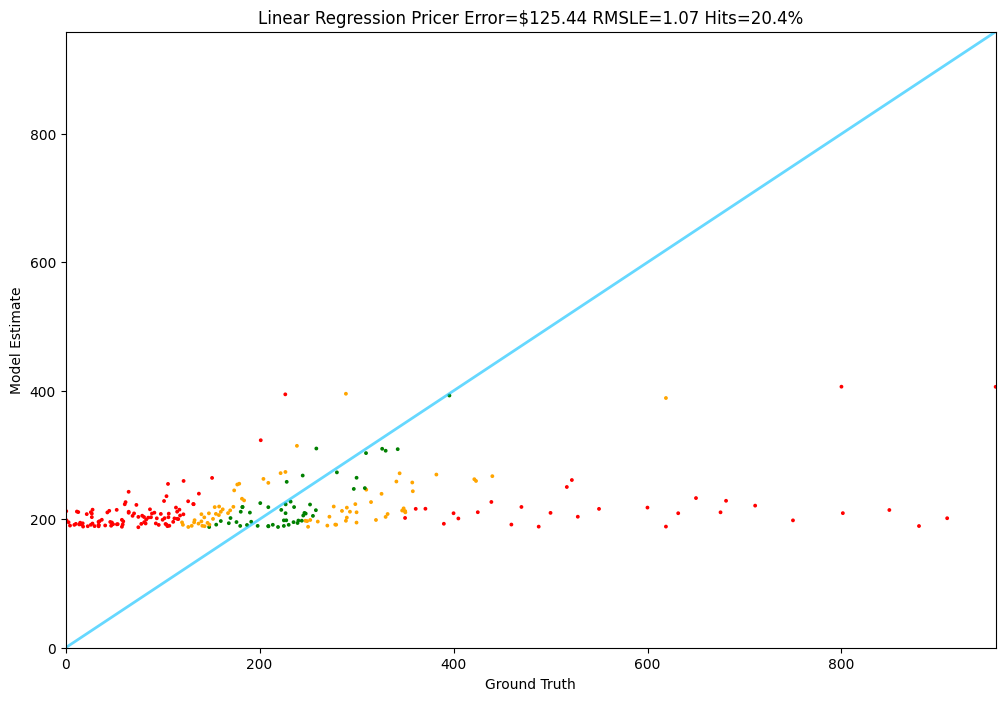

In [30]:
Tester.test(linear_regression_pricer)

## NLP

In [31]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [32]:
np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [33]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $213.49 Truth: $244.99 Error: $31.50 SLE: 0.02 Item: ECR4Kids Double-Sided Mobile Book Displa...
2: Guess: $137.25 Truth: $349.99 Error: $212.74 SLE: 0.87 Item: SINGCALL Wireless Construction Site Call...
3: Guess: $302.43 Truth: $232.00 Error: $70.43 SLE: 0.07 Item: VANGUARD VGUBG-1304-2141BK Black Powderc...
4: Guess: $314.14 Truth: $104.99 Error: $209.15 SLE: 1.19 Item: Corsair A500 High Performance Dual Fan C...
5: Guess: $234.93 Truth: $27.76 Error: $207.17 SLE: 4.43 Item: Shower Door Polycarbonate with 90 Degree...
6: Guess: $202.34 Truth: $17.58 Error: $184.76 SLE: 5.73 Item: Crescent 12" Indexing Nail Puller - DB12...
7: Guess: $42.61 Truth: $52.64 Error: $10.03 SLE: 0.04 Item: Coleman Cable Primary 10 Gauge 100', Mod...
8: Guess: $195.37 Truth: $101.46 Error: $93.91 SLE: 0.42 Item: Newport Brass 2-279 Metropole Solid Bras...
9: Guess: $178.90 Truth: $58.02 Error: $120.88 SLE: 1.24 Item: Syba 4 Port SATA III PCI-e 2.0 x1 Contro...
10: Guess: $278.98 Truth: $309.73 Err

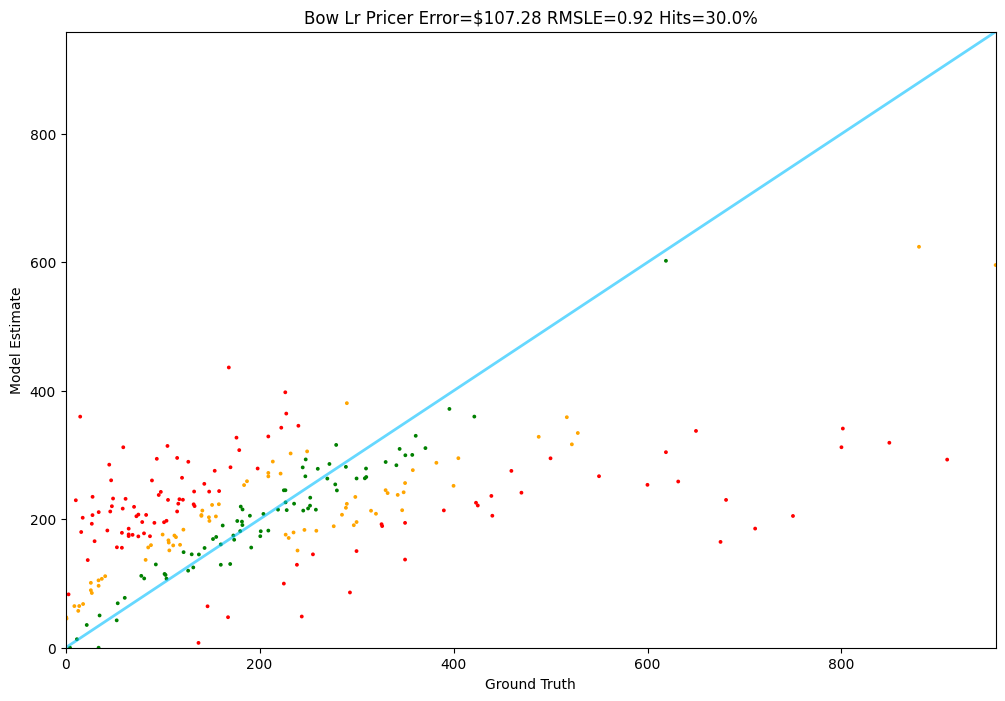

In [34]:
Tester.test(bow_lr_pricer)

In [35]:
np.random.seed(42)

processed_docs = [simple_preprocess(docs) for docs in documents]
w2v_model = Word2Vec(sentences=processed_docs,vector_size=400,window=5,min_count=1,workers=8)

In [37]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [39]:
word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v,prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [40]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $173.29 Truth: $244.99 Error: $71.70 SLE: 0.12 Item: ECR4Kids Double-Sided Mobile Book Displa...
2: Guess: $184.78 Truth: $349.99 Error: $165.21 SLE: 0.40 Item: SINGCALL Wireless Construction Site Call...
3: Guess: $197.96 Truth: $232.00 Error: $34.04 SLE: 0.02 Item: VANGUARD VGUBG-1304-2141BK Black Powderc...
4: Guess: $263.35 Truth: $104.99 Error: $158.36 SLE: 0.84 Item: Corsair A500 High Performance Dual Fan C...
5: Guess: $171.80 Truth: $27.76 Error: $144.04 SLE: 3.22 Item: Shower Door Polycarbonate with 90 Degree...
6: Guess: $136.48 Truth: $17.58 Error: $118.90 SLE: 4.01 Item: Crescent 12" Indexing Nail Puller - DB12...
7: Guess: $65.38 Truth: $52.64 Error: $12.74 SLE: 0.05 Item: Coleman Cable Primary 10 Gauge 100', Mod...
8: Guess: $248.62 Truth: $101.46 Error: $147.16 SLE: 0.79 Item: Newport Brass 2-279 Metropole Solid Bras...
9: Guess: $212.62 Truth: $58.02 Error: $154.60 SLE: 1.65 Item: Syba 4 Port SATA III PCI-e 2.0 x1 Contro...
10: Guess: $228.37 Truth: $309.73 Er

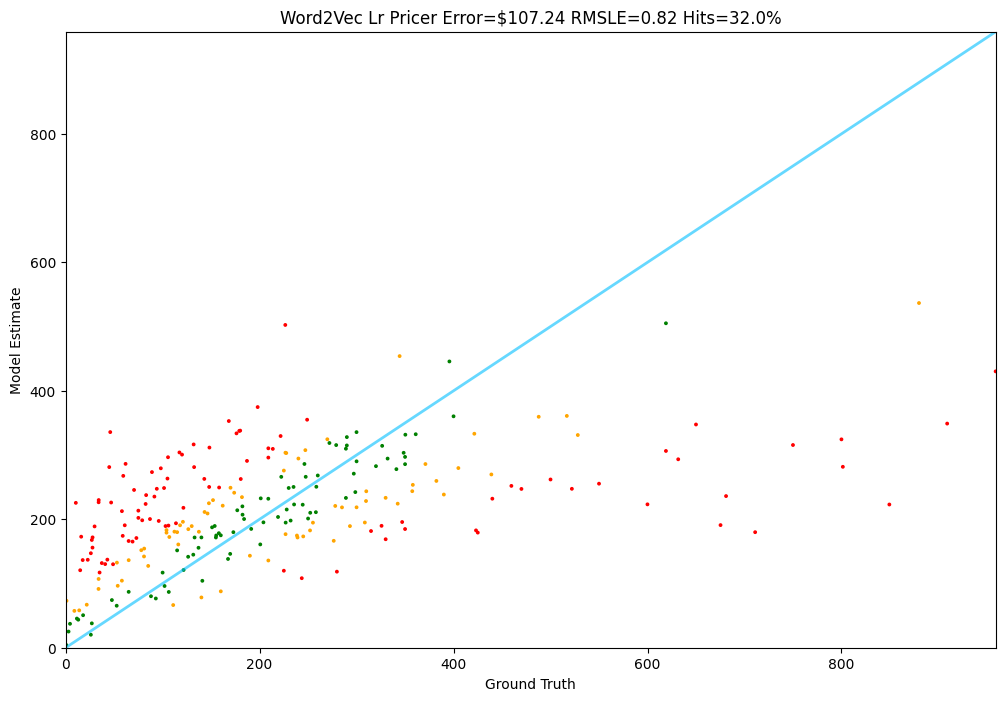

In [41]:
Tester.test(word2vec_lr_pricer)

In [42]:
np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v,prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [60]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)


1: Guess: $135.38 Truth: $244.99 Error: $109.61 SLE: 0.35 Item: ECR4Kids Double-Sided Mobile Book Displa...
2: Guess: $123.86 Truth: $349.99 Error: $226.13 SLE: 1.07 Item: SINGCALL Wireless Construction Site Call...
3: Guess: $192.67 Truth: $232.00 Error: $39.33 SLE: 0.03 Item: VANGUARD VGUBG-1304-2141BK Black Powderc...
4: Guess: $202.48 Truth: $104.99 Error: $97.49 SLE: 0.43 Item: Corsair A500 High Performance Dual Fan C...
5: Guess: $72.38 Truth: $27.76 Error: $44.62 SLE: 0.88 Item: Shower Door Polycarbonate with 90 Degree...
6: Guess: $123.75 Truth: $17.58 Error: $106.17 SLE: 3.63 Item: Crescent 12" Indexing Nail Puller - DB12...
7: Guess: $81.23 Truth: $52.64 Error: $28.59 SLE: 0.18 Item: Coleman Cable Primary 10 Gauge 100', Mod...
8: Guess: $207.36 Truth: $101.46 Error: $105.90 SLE: 0.50 Item: Newport Brass 2-279 Metropole Solid Bras...
9: Guess: $153.51 Truth: $58.02 Error: $95.49 SLE: 0.93 Item: Syba 4 Port SATA III PCI-e 2.0 x1 Contro...
10: Guess: $230.98 Truth: $309.73 Error

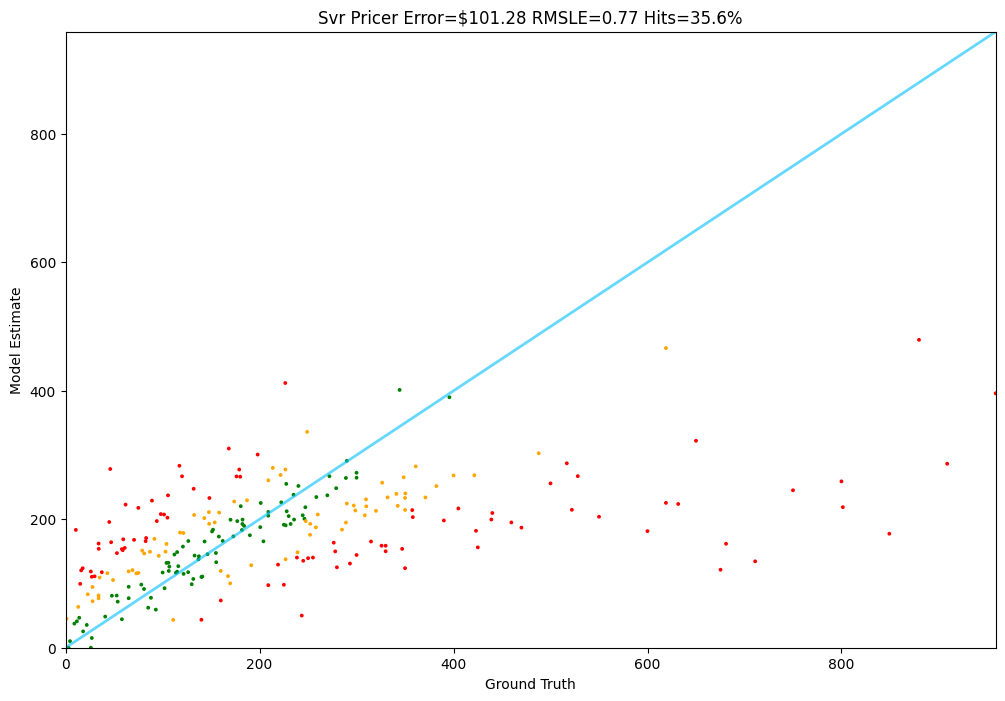

In [61]:
Tester.test(svr_pricer)

In [44]:
rf_model = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=8)
rf_model.fit(X_w2v,prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [56]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0,rf_model.predict([doc_vector])[0])

1: Guess: $123.66 Truth: $244.99 Error: $121.33 SLE: 0.46 Item: ECR4Kids Double-Sided Mobile Book Displa...
2: Guess: $198.05 Truth: $349.99 Error: $151.94 SLE: 0.32 Item: SINGCALL Wireless Construction Site Call...
3: Guess: $238.32 Truth: $232.00 Error: $6.32 SLE: 0.00 Item: VANGUARD VGUBG-1304-2141BK Black Powderc...
4: Guess: $230.83 Truth: $104.99 Error: $125.84 SLE: 0.61 Item: Corsair A500 High Performance Dual Fan C...
5: Guess: $235.70 Truth: $27.76 Error: $207.94 SLE: 4.44 Item: Shower Door Polycarbonate with 90 Degree...
6: Guess: $186.35 Truth: $17.58 Error: $168.77 SLE: 5.34 Item: Crescent 12" Indexing Nail Puller - DB12...
7: Guess: $137.68 Truth: $52.64 Error: $85.04 SLE: 0.90 Item: Coleman Cable Primary 10 Gauge 100', Mod...
8: Guess: $275.21 Truth: $101.46 Error: $173.75 SLE: 0.98 Item: Newport Brass 2-279 Metropole Solid Bras...
9: Guess: $152.63 Truth: $58.02 Error: $94.61 SLE: 0.92 Item: Syba 4 Port SATA III PCI-e 2.0 x1 Contro...
10: Guess: $287.11 Truth: $309.73 Er

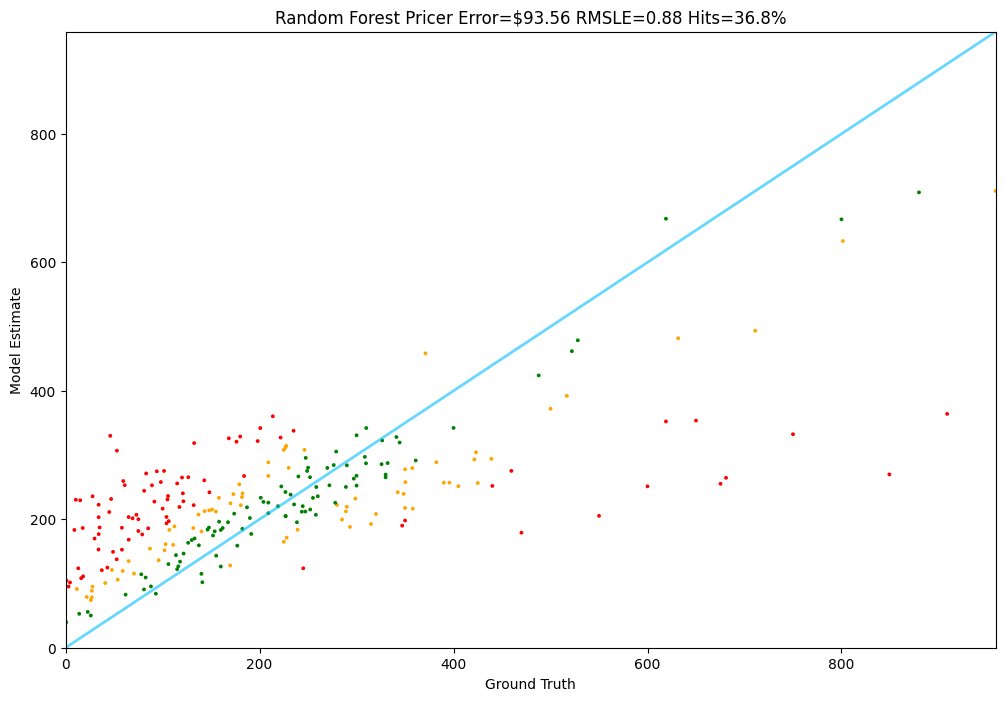

In [57]:
Tester.test(random_forest_pricer)